# Problem to be solved: create a Machine Learning model to predict the occurrence of diseases

Data source: National Institute of Diabetes and Digestive and Kidney Diseases

Competition page: https://www.kaggle.com/c/competicao-dsa-machine-learning-jan-2019/

# Exploratory Data Analysis 

Data fields:
* num_gestacoes - Number of times pregnant
* glicose - Plasma glucose concentration in oral glucose tolerance test
* pressao_sanguinea - Diastolic blood pressure in mm Hg
* grossura_pele - Thickness of the triceps skin fold in mm
* insulina - Insulin (mu U / ml)
* bmi - Body mass index measured by weight in kg / (height in m) ^ 2
* indice_historico - Diabetes History Index (Pedigree Function)
* idade - Age in years
* classe - Class (0 - did not develop disease / 1 - developed disease)

## Loading the data

In [1]:
# Importing packages
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
data = pd.read_csv('data/dataset_treino.csv')
test_data = pd.read_csv('data/dataset_teste.csv')
data.head(5)

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


## Data overview

In [2]:
# General statistics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
id                   600 non-null int64
num_gestacoes        600 non-null int64
glicose              600 non-null int64
pressao_sanguinea    600 non-null int64
grossura_pele        600 non-null int64
insulina             600 non-null int64
bmi                  600 non-null float64
indice_historico     600 non-null float64
idade                600 non-null int64
classe               600 non-null int64
dtypes: float64(2), int64(8)
memory usage: 47.0 KB


All 10 predictors variables are quantitative (numerical) and we have 600 observations to build the prediction model.

The only qualitative column is the labels, where:

* 0 - do not have the disease
* 1 - have the disease


## Data Cleaning

### Checking if there is missing values

In [3]:
# If the result is False, there is no missing value
data.isnull().values.any()

False

### Computing statistics for each column

In [4]:
data.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,300.500000,3.820000,120.135000,68.681667,20.558333,79.528333,31.905333,0.481063,33.278333,0.346667
std,173.349358,3.362009,32.658246,19.360226,16.004588,116.490583,8.009638,0.337284,11.822315,0.476306
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,150.750000,1.000000,99.000000,64.000000,0.000000,0.000000,27.075000,0.248000,24.000000,0.000000
50%,300.500000,3.000000,116.000000,70.000000,23.000000,36.500000,32.000000,0.384000,29.000000,0.000000
75%,450.250000,6.000000,140.000000,80.000000,32.000000,122.750000,36.525000,0.647000,40.000000,1.000000
max,600.000000,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


From the table above, we can see the zero values in almost all columns. But for some columns (e.g. *glicose*) we cannot have a zero value. So we need to treat these values.

After read some papers about the variables in the dataset, I see that some columns can have a value very close to zero (e.g. *grossura_pele*), but others can't have a zero value. 

The columns that can not have a zero value. 
* glicose
* pressao_sanguinea
* bmi

Let's see the number of the ocurrences of zero values for each of the columns:


In [5]:
# Compute the number of occurrences of a zero value 
for c in ['glicose', 'pressao_sanguinea', 'bmi']:
    counter = len(data[data[c] == 0])    
    print('{} - {}'.format(c, counter))    

glicose - 5
pressao_sanguinea - 28
bmi - 9


Let's remove these observations of our data.

In [6]:
# Removing observations with zero value
for c in ['glicose', 'pressao_sanguinea', 'bmi']:
    data = data[data[c] != 0]

data.shape

(564, 10)

The final number of observations was 564. 

Let's see the compute some statistics again:

In [7]:
data.describe()

,id,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,300.664894,3.845745,121.354610,72.049645,21.432624,84.406028,32.367199,0.483294,33.448582,0.340426
std,173.410435,3.349287,31.130992,12.261552,15.809953,118.432015,6.974710,0.337668,11.868844,0.474273
min,1.000000,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,150.750000,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.250500,24.000000,0.000000
50%,298.500000,3.000000,116.000000,72.000000,23.500000,49.000000,32.000000,0.389000,29.000000,0.000000
75%,450.250000,6.000000,141.250000,80.000000,33.000000,130.000000,36.600000,0.648250,41.000000,1.000000
max,600.000000,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Checking outliers

Let's check if there is ouliers in the data.

First, we'll use a set of boxplots, one for each column.

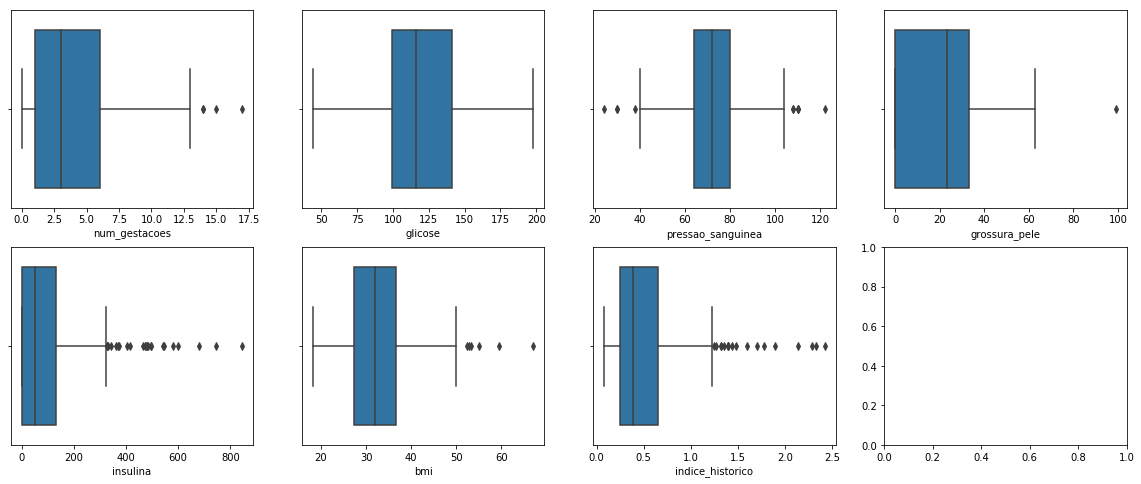

In [8]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

x,y = 0,0
for i, column in enumerate(data.columns[1:-2]):    
    sns.boxplot(x=data[column], ax=axes[x,y])
    if i < 3:
        y += 1
    elif i == 3: 
        x = 1
        y = 0
    else:
        y += 1

We can see some possible outliers for almost all columns (separated points in the plots), except *glicose* column.

The outliers can either be a mistake or just variance. For now, let's consider all of than as a mistakes.

To remove these outliers we can use Z-Score or IQR (Interquartile Range).

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1. While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

Let's use Z-score function defined in scipy library to detect the outliers:

In [9]:
# Compute the Z-Score for each columns
data_cleaned = data.copy()   
z = np.abs(stats.zscore(data))    
data_cleaned = data_cleaned[(z < 3).all(axis=1)]   

print(data.shape)
print(data_cleaned.shape)    

(564, 10)
(531, 10)


Using Z-Score, 33 observations where removed.

Let's see the boxplots again:

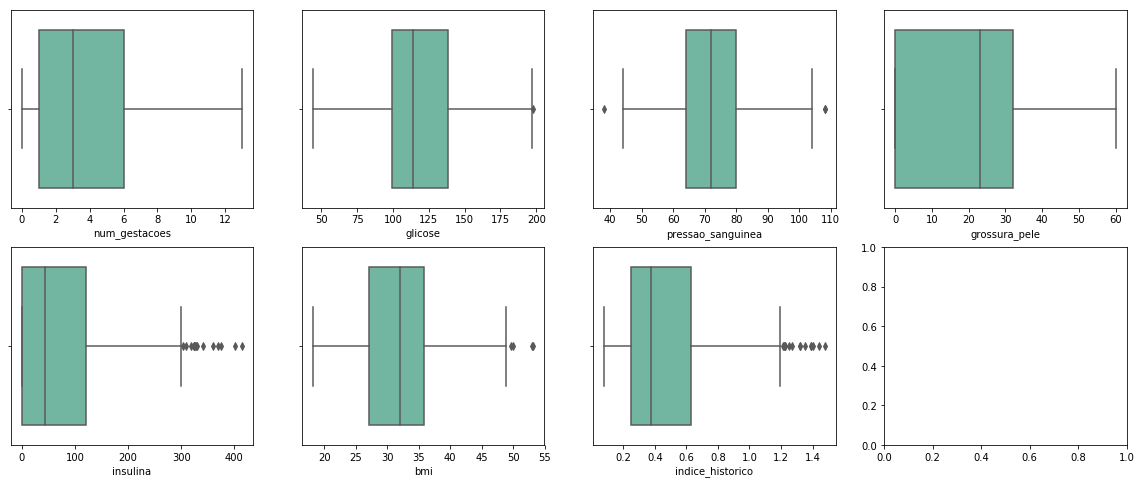

In [10]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

x,y = 0,0
for i, column in enumerate(data_cleaned.columns[1:-2]):    
    sns.boxplot(x=data_cleaned[column], ax=axes[x,y], palette="Set2")
    if i < 3:
        y += 1
    elif i == 3: 
        x = 1
        y = 0
    else:
        y += 1

The data was much cleaner now. Still, there are some points in the boxplots, but some of them are not outliers, like the *insulina* values higher than 400, which is normal in people with diabetes. 

### Checking the balance of the dataset

Let's checking the distribuitions of examples for each label:

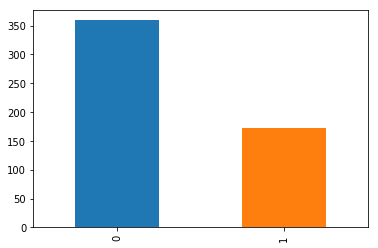

In [11]:
data_cleaned.classe.value_counts().plot(kind='bar');

In [12]:
data_cleaned.classe.value_counts(normalize=True)

0    0.676083
1    0.323917
Name: classe, dtype: float64

From the figure above, we see most of our examples are of people that do not have the diasese. More specically, 67% of the data are for health people.
Despite the dataset is unabalanced, as we have a low number of samples, I prefer do not change anything at this moment.


# Training the Model

Now that data is cleaned, let's train use a machine learning model to predict whether or not a person has diabetes.

https://scikit-learn.org/stable/modules/tree.html

### Using Decision Tree

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

# Select the columns with features
features = ['num_gestacoes', 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi', 'indice_historico', 'idade']
X = data_cleaned[features]
# Select the columns with labels
Y = data_cleaned['classe']

# Perform the training and test 100 times with different seeds and compute the mean accuracy.
# Save results
acurrances = []
for i in range(100):    
    # Spliting Dataset into Test and Train
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)

    # Create and train the model
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=i)
    clf.fit(X_train,y_train)

    # Performing predictions with test dataset
    y_pred = clf.predict(X_test)
    # Computing accuracy    
    acurrances.append(accuracy_score(y_test, y_pred)*100)

print('Accuracy is ', np.mean(acurrances))

Accuracy is  69.55


## Performing the Prediction

In [14]:
# Create and train the model with all data
clf = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=2)
clf.fit(data_cleaned[features], data_cleaned['classe'])

# Get the kaggle test data
X_test = test_data[features]
# Make the prediction 
prediction = clf.predict(X_test)

# Add the predictions to the dataframe 
test_data['classe'] = prediction

# Create the submission file
test_data.loc[:,['id', 'classe']].to_csv('submission.csv', encoding='utf-8', index=False)

# To do list:
* Check the zero values in INSULINA e GROSSURA_PELE
* Try remove outliers with IQR
* Try decision tree, Naive Bayes and SVM
* Balance the dataset
